In [2]:
import keras
keras.__version__

'3.4.1'

In [3]:
import cv2, os, json
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical, img_to_array
from keras.backend import image_data_format
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy, binary_crossentropy
from keras.metrics import categorical_accuracy, sparse_categorical_accuracy, binary_accuracy
from keras.datasets import cifar10
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, Callback

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

**Preprocessors**

In [4]:
class SimpleDatasetLoader:
  def __init__(self, preprocessor=None):
    self.preprocessor = preprocessor or []

  def load(self, imagePaths):
    data = []
    labels = []

    for imagePath in imagePaths:
      image = cv2.imread(imagePath)
      label = imagePath.split(os.path.sep)[-2]

      labels.append(label)

      if self.preprocessor:
        for p in self.preprocessor:
          image = p.preprocess(image)

      data.append(image)

    return (np.array(data), np.array(labels))

In [5]:
class SimplePreprocessor:
  def __init__(self, width, height, inter=cv2.INTER_AREA):
    self.width = width
    self.height = height
    self.inter = inter

  def preprocess(self, image):
    return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [6]:
class ImageToArrayPreprocessor:
  def __init__(self, dataFormat=None):
    self.dataFormat = dataFormat

  def preprocess(self, image):
    return img_to_array(image, data_format=self.dataFormat)

In [19]:
import imutils
class AspectAwarePreprocessor:
  def __init__(self, width, height, inter=cv2.INTER_AREA):
    self.width = width
    self.height = height
    self.inter = inter

  def preprocess(self, image):
    # grab the dimensions of the image and then initialize
    # the deltas to use when cropping
    (h, w) = image.shape[:2]
    dW = 0
    dH = 0
    # if the width is smaller than the height, then resize
    # along the width (i.e., the smaller dimension) and then
    # update the deltas to crop the height to the desired
    # dimension
    if w < h:
      image = imutils.resize(image, width=self.width,
      inter=self.inter)
      dH = int((image.shape[0] - self.height) / 2.0)
      # otherwise, the height is smaller than the width so
      # resize along the height and then update the deltas
      # to crop along the width
    else:
      image = imutils.resize(image, height=self.height,
      inter=self.inter)
      dW = int((image.shape[1] - self.width) / 2.0)
    # now that our images have been resized, we need to
    # re-grab the width and height, followed by performing
    # the crop
    (h, w) = image.shape[:2]
    image = image[dH:h - dH, dW:w - dW]

    # finally, resize the image to the provided spatial
    # dimensions to ensure our output image is always a fixed
    # size
    return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

**Callbacks**

In [7]:
def step_decay(epoch):
  # initialize the base initial learning rate, drop factor, and
  # epochs to drop every
  initAlpha = 0.01
  factor = 0.25
  dropEvery = 5

  # compute learning rate for the current epoch
  alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
  return float(alpha)

learning_rate_callback = LearningRateScheduler(step_decay)

In [8]:
class TrainingMonitor(Callback):
  def __init__(self, figPath, jsonPath=None, startAt=0):
    super(TrainingMonitor, self).__init__()
    self.figPath = figPath
    self.jsonPath = jsonPath
    self.startAt = startAt

  def on_train_begin(self, logs={}):
    print (logs, "begin")
    self.H = {}

    if self.jsonPath is not None:
      if os.path.exists(self.jsonPath):
        self.H = json.loads(open(self.jsonPath).read())

        if self.startAt > 0:
          for k in self.H.keys():
            self.H[k] = self.H[k][:self.startAt]

  def on_epoch_end(self, epoch, logs={}):
    print (logs, "end")
    for (k, v) in logs.items():
      l = self.H.get(k, [])
      l.append(float(v))
      self.H[k] = l

      if self.jsonPath is not None:
        f = open(self.jsonPath, "w")
        f.write(json.dumps(self.H))
        f.close()

    if len(self.H["loss"]) > 1:
      N = np.arange(0, len(self.H["loss"]))
      plt.style.use("ggplot")
      plt.figure()

      plt.plot(N, self.H["loss"], label="train_loss")
      plt.plot(N, self.H["val_loss"], label="val_loss")
      plt.plot(N, self.H["accuracy"], label="train_acc")
      plt.plot(N, self.H["val_accuracy"], label="val_acc")
      plt.title("Training Loss and Accuracy [Epoch {}]".format(len(self.H["loss"])))
      plt.xlabel("Epoch #")
      plt.ylabel("Loss/Accuracy")
      plt.legend()

      plt.savefig(self.figPath)
      plt.close()

figPath = "/content/sample_data/plots/{}.png".format(os.getpid())
jsonPath = "/content/sample_data/json_paths/{}.json".format(os.getpid())
training_monitor = TrainingMonitor(figPath, jsonPath=jsonPath)

In [9]:
fname = os.path.sep.join(["/content/sample_data", "weights-{epoch:03d}-{val_loss:.4f}.keras"])
checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

**Models**

In [5]:
class ShallowNet():
  @staticmethod
  def build(width, height, depth, classes):
    input_shape = (height, width, depth)
    if image_data_format() == 'channels_first':
      input_shape = (depth, height, width)

    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(classes, activation="softmax"),
    ])
    return model

In [15]:
class MiniVGGNet:
  def build(width, height, depth, classes):
    input_shape = (height, width, depth)
    chanDim = -1
    if image_data_format() == 'channels_first':
      input_shape = (depth, height, width)
      chanDim = 0

    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(axis=chanDim),
        Conv2D(64, (3, 3), padding='same', activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(axis=chanDim),
        Flatten(),
        Dense(512, activation="relu"),
        BatchNormalization(axis=chanDim),
        Dropout(0.5),
        Dense(classes, activation="softmax"),
    ])
    return model


In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float")/255.0
x_test = x_test.astype("float")/255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [8]:
opt = SGD(learning_rate=0.01)
shallow_model = ShallowNet.build(32, 32, 3, 10)
shallow_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = shallow_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=40, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.2658 - loss: 2.0374 - val_accuracy: 0.3465 - val_loss: 1.7771
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4349 - loss: 1.6356 - val_accuracy: 0.4361 - val_loss: 1.5833
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4984 - loss: 1.4546 - val_accuracy: 0.5101 - val_loss: 1.3815
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5339 - loss: 1.3477 - val_accuracy: 0.5276 - val_loss: 1.3247
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5555 - loss: 1.2766 - val_accuracy: 0.5554 - val_loss: 1.2644
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5698 - loss: 1.2444 - val_accuracy: 0.5458 - val_loss: 1.2874
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5800 - loss: 1.2200 - val_accuracy: 0.5639 - val_loss: 1.2377
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5872 - loss: 1.1859

In [9]:
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
predictions = shallow_model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.75      0.51      0.61      1000
  automobile       0.85      0.58      0.69      1000
        bird       0.74      0.14      0.23      1000
         cat       0.67      0.12      0.21      1000
        deer       0.36      0.83      0.50      1000
         dog       0.64      0.43      0.51      1000
        frog       0.71      0.68      0.69      1000
       horse       0.59      0.78      0.67      1000
        ship       0.60      0.84      0.70      1000
       truck       0.54      0.86      0.66      1000

    accuracy                           0.58     10000
   macro avg       0.64      0.58      0.55     10000
weighted avg       0.64      0.58      0.55     10000



In [21]:
def plot_history(history):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, 2), history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, 2), history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, 2), history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, 2), history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

# plot_history(history)

{} begin
Epoch 1/2
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3756 - loss: 2.0143
Epoch 1: val_loss did not improve from 1.23102
{'accuracy': 0.44670000672340393, 'loss': 1.6729047298431396, 'val_accuracy': 0.5252000093460083, 'val_loss': 1.3668460845947266, 'learning_rate': 0.009999999776482582} end
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 171s 107ms/step - accuracy: 0.3757 - loss: 2.0138 - val_accuracy: 0.5252 - val_loss: 1.3668 - learning_rate: 0.0100
Epoch 2/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5573 - loss: 1.2450
Epoch 2: val_loss did not improve from 1.23102
{'accuracy': 0.5718600153923035, 'loss': 1.213756799697876, 'val_accuracy': 0.47679999470710754, 'val_loss': 1.6373540163040161, 'learning_rate': 0.009999999776482582} end
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 80ms/step - accuracy: 0.5573 - loss: 1.2450 - val_accuracy: 0.4768 - val_loss: 1.6374 - learning_rate: 0.0100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
              precision    recall  f1-sco

ValueError: x and y must have same first dimension, but have shapes (40,) and (2,)

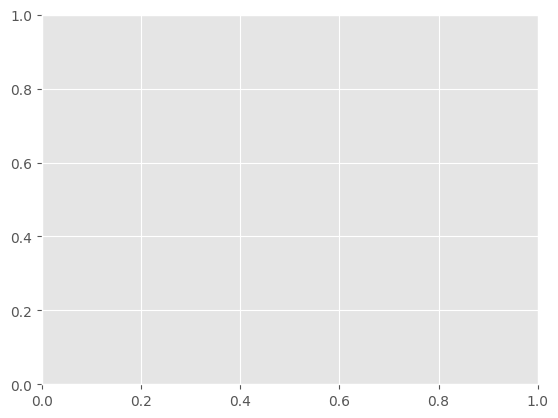

In [18]:
opt = SGD(learning_rate=0.01)
vgg_model = MiniVGGNet.build(32, 32, 3, 10)
vgg_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = vgg_model.fit(
    x_train, y_train, validation_data=(x_test, y_test),
    callbacks=[learning_rate_callback, checkpoint, training_monitor],
    batch_size=32, epochs=2, verbose=1)

labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
predictions = vgg_model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))



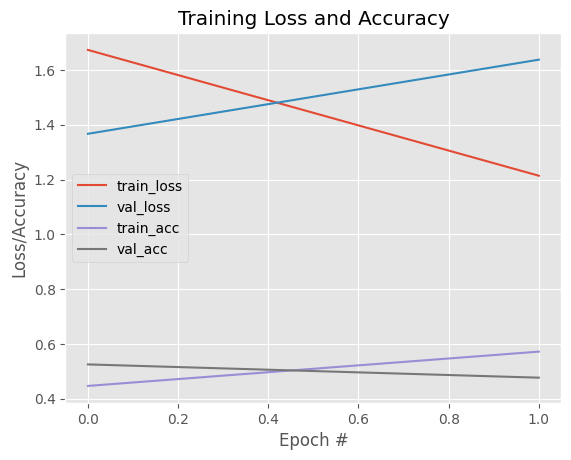

In [22]:
plot_history(history)

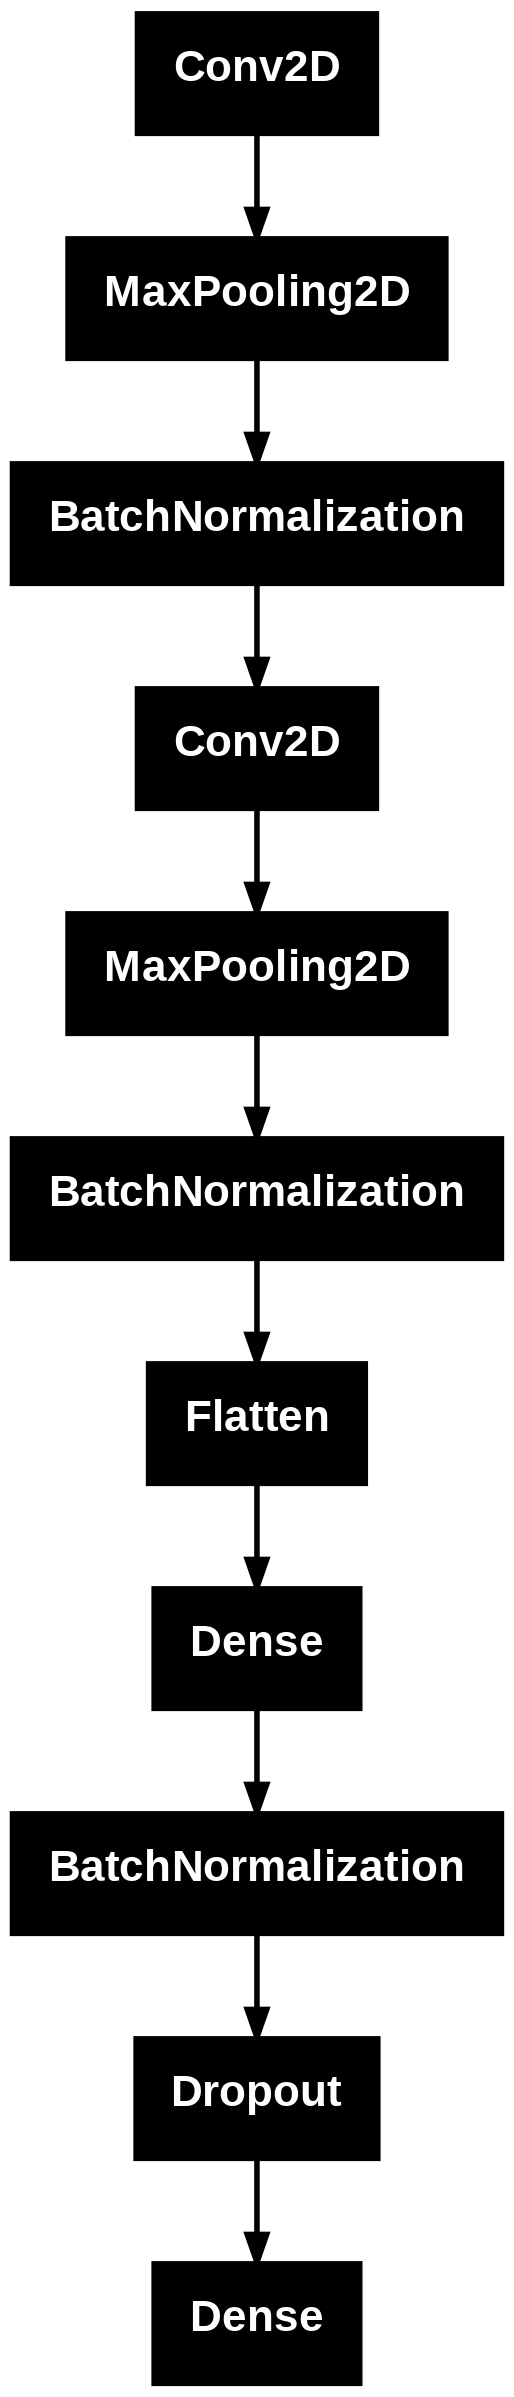

In [23]:
from keras.utils import plot_model
plot_model(vgg_model, to_file='model.png')

**Transfer learning feature extraction**

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Load pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

# Load and preprocess image
img_path = '/content/sample_data/dash.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract features
features = model.predict(x)
print(features.shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1, 7, 7, 512)


In [ ]:
import h5py
import os

class HDF5DatasetWriter:
  def __init__(self, dims, outputPath, dataKey="images", bufSize=1000):
    if os.path.exists(outputPath):
      raise ValueError("The supplied `outputPath` already exists and cannot be overwritten. Manually delete the file before continuing", outputPath)

    self.db = h5py.File(outputPath, "w")
    self.data = self.db.create_dataset(dataKey, dims, dtype="float")
    self.labels = self.db.create_dataset("labels", (dims[0],), dtype="int")

    self.bufSize = bufSize
    self.buffer = {"data": [], "labels": []}
    self.idx = 0

  def add(self, rows, labels):
    self.buffer["data"].extend(rows)
    self.buffer["labels"].extend(labels)

    if len(self.buffer["data"]) >= self.bufSize:
      self.flush()

  def flush(self):
    i = self.idx + len(self.buffer["data"])
    self.data[self.idx:i] = self.buffer["data"]
    self.labels[self.idx:i] = self.buffer["labels"]
    self.idx = i
    self.buffer = {"data": [], "labels": []}

  def storeClassLabels(self, classLabels):
    dt = h5py.special_dtype(vlen=str)
    labelSet = self.db.create_dataset("label_names", (len(classLabels),), dtype=dt)
    labelSet[:] = classLabels

  def close(self):
    if len(self.buffer["data"]) > 0:
      self.flush()

    self.db.close()